## Setting all Required Values

In [54]:
import math
import numpy as np
import skrf as rf
import matplotlib.pyplot as plt
import pandas as pd
# want to graph frequency vs attenuation

omegas = np.linspace(70e6, 130e6) * np.pi * 2

freq_cutoff = 100e6
omega_cutoff = freq_cutoff * 2 * np.pi
pb_allowable_ripple = 1 # 1dB of allowable ripple in the passband

epsilon = np.sqrt( np.pow(10, pb_allowable_ripple / 10) - 1)
n = 3 # order that we're using

B = 1/n * np.arccosh(1/epsilon)
inv_ratio = (omegas/omega_cutoff) * np.cosh(B) # (w/wc)'

def C_3 (x):
    return 4 * np.power(x, 3) - 3 * x

attenuation = 10 * np.log10(1 + np.power(epsilon, 2) * np.power( C_3(inv_ratio), 2))

## Uses the math found within the RF Circuitry book to build an analytical model of the LPF Chebyshev filter we're building
def buildAtt(start_w, end_w):

    omegas = np.linspace(start_w, end_w, 1000000) * np.pi * 2

    freq_cutoff = 100e6
    omega_cutoff = freq_cutoff * 2 * np.pi
    pb_allowable_ripple = 0.5 # 1dB of allowable ripple in the passband
    
    epsilon = np.sqrt( np.pow(10, pb_allowable_ripple / 10) - 1)
    print("Epsilon ", epsilon)
    
    n = 3 # order that we're using
    
    B = 1/n * np.arccosh(1/epsilon)
    inv_ratio = (omegas/omega_cutoff) * np.cosh(B) # (w/wc)'

    attenuation = 10 * np.log10(1 + np.power(epsilon, 2) * np.power( C_3(inv_ratio), 2)  )
    return (omegas, attenuation)

## Finds the index of the value closest to our desired value within an array
def find(arr, val):
    diff_mat = arr - np.ones(len(arr))*val
    return np.argmin(np.abs(diff_mat))

def C_3 (x):
    return 4 * np.power(x, 3) - 3 * x

## Defining the Things I will be Comparing

In [55]:
analytical_freq, analytical_db = buildAtt(40e6, 130e6)
s21_AnalyticalSim = rf.Network(frequency = analytical_freq, s = analytical_db)

analytical_freq = analytical_freq/(2*np.pi)
analytical_db = -analytical_db

Epsilon  0.34931140018894796


In [56]:
filename = "dp1_40to130.txt"
frequency_arr = []
s_arr = []

with open(filename, 'r') as input_file:
    line_array = input_file.readlines()

    # Change first line to s1p format
    line_array[0] = "# MHz S MA R 50"

    j = 0
    # LTspice exports with commas, change to spaces
    for idx, line in enumerate(line_array[1:]):
        line_array[idx] = line.replace(",", " ")
        
        arr = [float(x) for x in line_array[idx].split()]
        
        frequency_arr.append(arr[0])
        
        s_arr.append([[arr[1]+1j*arr[2], arr[3]+1j*arr[4]],
                      [arr[5]+1j*arr[6], arr[7]+1j*arr[8]]])

f_arr = np.array(frequency_arr)
svals_arr = np.array(s_arr)

s21_IdealSim = rf.Network(frequency = f_arr, s = svals_arr[:,1,0])

In [57]:
filename = "dp1_40to130_real.txt"

frequency_arr = []
s_arr = []

with open(filename, 'r') as input_file:
    line_array = input_file.readlines()

    # Change first line to s1p format
    line_array[0] = "# MHz S MA R 50"

    j = 0
    # LTspice exports with commas, change to spaces
    for idx, line in enumerate(line_array[1:]):
        line_array[idx] = line.replace(",", " ")
        
        arr = [float(x) for x in line_array[idx].split()]
        
        frequency_arr.append(arr[0])
        
        s_arr.append([[arr[1]+1j*arr[2], arr[3]+1j*arr[4]],
                      [arr[5]+1j*arr[6], arr[7]+1j*arr[8]]])

f_arr = np.array(frequency_arr)
svals_arr = np.array(s_arr)

s21_RealSim = rf.Network(frequency = f_arr, s = svals_arr[:,1,0])

In [58]:
csv13 = pd.read_csv('CSV13.csv', skiprows=13)
csv13.columns = ['Frequency', 'Z_Real', 'Z_Imag', 'components', 'H']
csv13['Z_n'] = csv13['Z_Real']/50 + 1j*csv13['Z_Imag']/50
csv13['S_21'] = ( csv13['Z_n']-1 ) / ( csv13['Z_n']+1 )
real_data_21 = rf.Network(frequency = csv13['Frequency'], s = csv13['S_21'], m=0, n=0)
marker_idx = [30, 60, 90]

start_val = real_data_21.s_db[0]
sval = (np.ones(len(real_data_21.s_db)) * start_val).T

my_arr = real_data_21.s_db[:,0,0]
my_frq = real_data_21.f

loc_at_3 = find(my_arr, -3)
freq_at_3 = my_frq[loc_at_3]/(2*np.pi)
att_at_3 = my_arr[loc_at_3]

loc_at_20 = find(my_arr, -20)
freq_at_20 = my_frq[loc_at_20]/(2*np.pi)
att_at_20 = my_arr[loc_at_20]

loc_100MHz = find(my_frq, 100e6)
loc_70MHz = find(my_frq, 70e6)
loc_300MHz = find(my_frq, 300e6)
marker_idx = [loc_70MHz, loc_100MHz, loc_300MHz]


Text(46707500.0, -10, 'Minimum Attenuation: \n(43.96 MHz, -1.02 dB)')

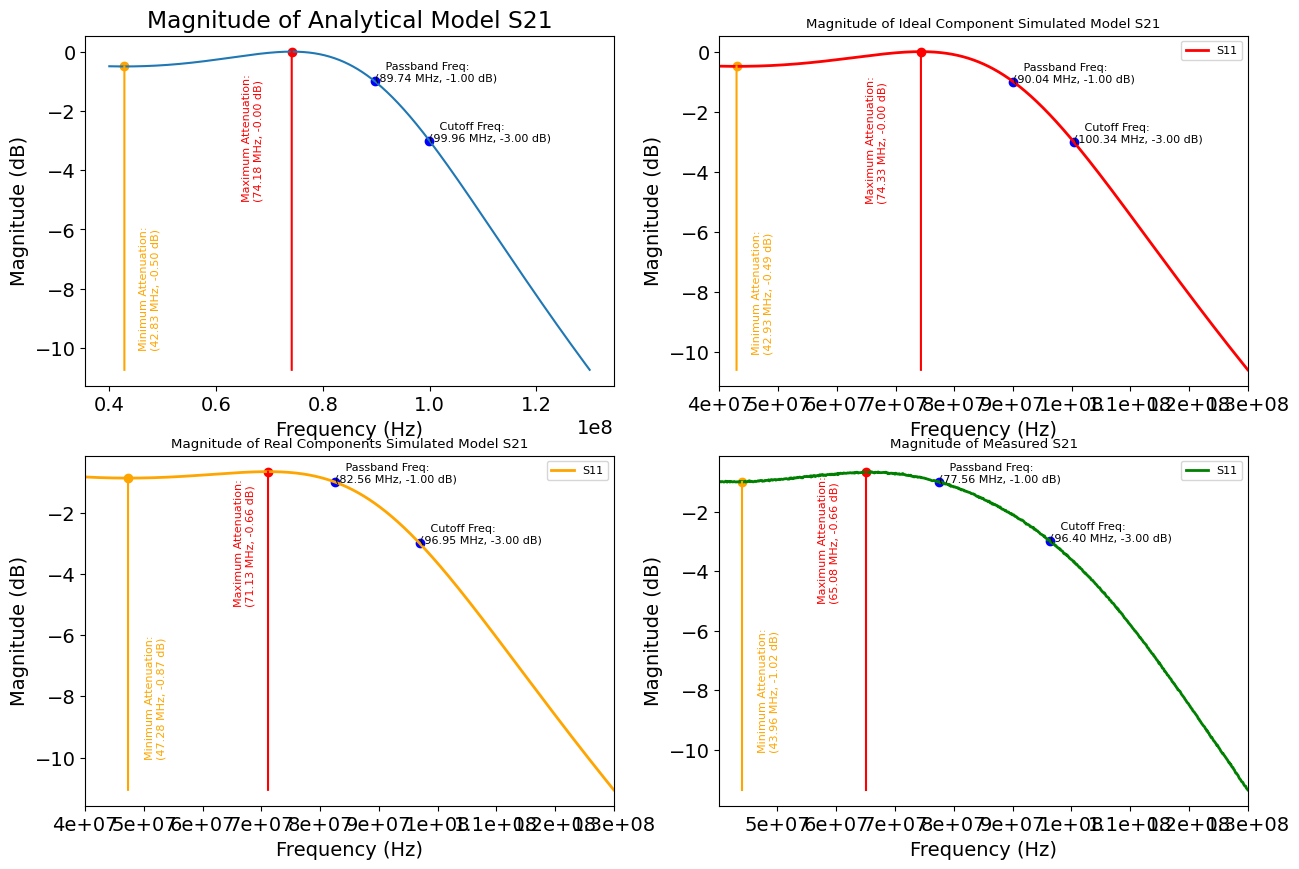

In [59]:
fig, axes = plt.subplots(2,2, figsize=[15,10])

## 0, 0 -> analytical
axCurr = axes[0][0]
axCurr.set_title("Magnitude of Analytical Model S21")
axCurr.set_xlabel("Frequency (Hz)")
axCurr.set_ylabel("Magnitude (dB)")
end = -1

db = analytical_db; freq = analytical_freq

loc1 = find(db, -1)
loc3 = find(db, -3)
locMax = find(db, 100)
locMin = find(db[:int(len(db)/4)], -1000)

axCurr.plot(freq, db)

plt.rcParams['font.size'] = 8
axCurr.scatter(freq[loc1], db[loc1], c='blue')


axCurr.annotate(f"   Passband Freq: \n({freq[loc1]/1e6:0.2f} MHz, {db[loc1]:0.2f} dB)", 
                                   (    freq[loc1],                db[loc1]))

axCurr.scatter(freq[loc3], db[loc3], c='blue')
axCurr.annotate(f"   Cutoff Freq: \n({freq[loc3]/1e6:0.2f} MHz, {db[loc3]:0.2f} dB)", 
                                     (freq[loc3],                db[loc3]) )

maxLine = np.ones(len(db)) * freq[locMax]
toPeak = np.linspace(min(db), db[locMax], len(db))
axCurr.plot(maxLine, toPeak, c="red")
axCurr.scatter(freq[locMax], db[locMax], c='red')
axCurr.annotate(f"Maximum Attenuation: \n({freq[locMax]/1e6:0.2f} MHz, {db[locMax]:0.2f} dB)", 
                                   (    freq[locMax] * 14/16,  -5 ), color="red" , rotation='vertical')


minLine = np.ones(len(db)) * freq[locMin]
toMinPeak = np.linspace(min(db), db[locMin], len(db))
axCurr.plot(minLine, toMinPeak, c="orange")
axCurr.scatter(freq[locMin], db[locMin], c='orange')
axCurr.annotate(f"Minimum Attenuation: \n({freq[locMin]/1e6:0.2f} MHz, {db[locMin]:0.2f} dB)", 
                                   (    freq[locMin] * 17/16,  -10 ), color="orange" , rotation='vertical')


## 0, 1 -> idealized components
axCurr = axes[0][1]
axCurr.set_title("Magnitude of Ideal Component Simulated Model S21")
axCurr.set_xlabel("Frequency (Hz)")
axCurr.set_ylabel("Attenuation (dB)")

db = s21_IdealSim.s_db[:,0,0]
freq = s21_IdealSim.f

s21_IdealSim.plot_s_db(ax=axCurr, color="red", linewidth=2)

loc1 = find(db, -1)
loc3 = find(db, -3)
locMax = find(db, 100)
locMin = find(db[:int(len(db)/4)], -1000)

plt.rcParams['font.size'] = 8
axCurr.scatter(freq[loc1], db[loc1], c='blue')
axCurr.annotate(f"   Passband Freq: \n({freq[loc1]/1e6:0.2f} MHz, {db[loc1]:0.2f} dB)", (freq[loc1], db[loc1]))
axCurr.scatter(freq[loc3], db[loc3], c='blue')
axCurr.annotate(f"   Cutoff Freq: \n({freq[loc3]/1e6:0.2f} MHz, {db[loc3]:0.2f} dB)", (freq[loc3], db[loc3]) )

maxLine = np.ones(len(db)) * freq[locMax]
toPeak = np.linspace(min(db), db[locMax], len(db))
axCurr.plot(maxLine, toPeak, c="red")
axCurr.scatter(freq[locMax], db[locMax], c='red')
axCurr.annotate(f"Maximum Attenuation: \n({freq[locMax]/1e6:0.2f} MHz, {db[locMax]:0.2f} dB)", 
                                   (    freq[locMax] * 14/16,  -5 ), color="red" , rotation='vertical')

minLine = np.ones(len(db)) * freq[locMin]
toMinPeak = np.linspace(min(db), db[locMin], len(db))
axCurr.plot(minLine, toMinPeak, c="orange")
axCurr.scatter(freq[locMin], db[locMin], c='orange')
axCurr.annotate(f"Minimum Attenuation: \n({freq[locMin]/1e6:0.2f} MHz, {db[locMin]:0.2f} dB)", 
                                   (    freq[locMin] * 17/16,  -10 ), color="orange" , rotation='vertical')


## 1, 0 -> real simulated components
axCurr = axes[1][0]
axCurr.set_title("Magnitude of Real Components Simulated Model S21")
axCurr.set_xlabel("Frequency (Hz)")
axCurr.set_ylabel("Attenuation (dB)")

db = s21_RealSim.s_db[:,0,0]
freq = s21_RealSim.f

s21_RealSim.plot_s_db(ax=axCurr, color="orange", linewidth=2)

loc1 = find(db, -1)
loc3 = find(db, -3)
locMax = find(db, 100)
locMin = find(db[:int(len(db)/4)], -1000)

plt.rcParams['font.size'] = 8
axCurr.scatter(freq[loc1], db[loc1], c='blue')
axCurr.annotate(f"   Passband Freq: \n({freq[loc1]/1e6:0.2f} MHz, {db[loc1]:0.2f} dB)", 
                                   ( freq[loc1], db[loc1]))

axCurr.scatter(freq[loc3], db[loc3], c='blue')
axCurr.annotate(f"   Cutoff Freq: \n({freq[loc3]/1e6:0.2f} MHz, {db[loc3]:0.2f} dB)", 
                                     (freq[loc3],                db[loc3]) )

maxLine = np.ones(len(db)) * freq[locMax]
toPeak = np.linspace(min(db), db[locMax], len(db))
axCurr.plot(maxLine, toPeak, c="red")
axCurr.scatter(freq[locMax], db[locMax], c='red')
axCurr.annotate(f"Maximum Attenuation: \n({freq[locMax]/1e6:0.2f} MHz, {db[locMax]:0.2f} dB)", 
                                   (    freq[locMax] * 14.7/16,  -5 ), color="red" , rotation='vertical')


minLine = np.ones(len(db)) * freq[locMin]
toMinPeak = np.linspace(min(db), db[locMin], len(db))
axCurr.plot(minLine, toMinPeak, c="orange")
axCurr.scatter(freq[locMin], db[locMin], c='orange')
axCurr.annotate(f"Minimum Attenuation: \n({freq[locMin]/1e6:0.2f} MHz, {db[locMin]:0.2f} dB)", 
                                   (    freq[locMin] * 17/16,  -10 ), color="orange" , rotation='vertical')

## 1, 1 -> lab data
axCurr = axes[1][1]
axCurr.set_title("Magnitude of Measured S21")
axCurr.set_xlabel("Frequency (Hz)")
axCurr.set_ylabel("Attenuation (dB)")

real_data_21.plot_s_db(ax=axCurr, color="green", linewidth=2)

db = real_data_21.s_db[:,0,0]
freq = real_data_21.f

loc1 = find(db[int(len(db)/10):], -1) + int(len(db)/10)
loc3 = find(db, -3)
locMax = find(db, 100)
locMin = find(db[:int(len(db)/4)], -1000)

plt.rcParams['font.size'] = 8
axCurr.scatter(freq[loc1], db[loc1], c='blue')
axCurr.annotate(f"   Passband Freq: \n({freq[loc1]/1e6:0.2f} MHz, {db[loc1]:0.2f} dB)", 
                                   (    freq[loc1],                db[loc1]))

axCurr.scatter(freq[loc3], db[loc3], c='blue')
axCurr.annotate(f"   Cutoff Freq: \n({freq[loc3]/1e6:0.2f} MHz, {db[loc3]:0.2f} dB)", 
                                     (freq[loc3],                db[loc3]) )

maxLine = np.ones(len(db)) * freq[locMax]
toPeak = np.linspace(min(db), db[locMax], len(db))
axCurr.plot(maxLine, toPeak, c="red")
axCurr.scatter(freq[locMax], db[locMax], c='red')
axCurr.annotate(f"Maximum Attenuation: \n({freq[locMax]/1e6:0.2f} MHz, {db[locMax]:0.2f} dB)", 
                                   (    freq[locMax] * 14/16,  -5 ), color="red" , rotation='vertical')


minLine = np.ones(len(db)) * freq[locMin]
toMinPeak = np.linspace(min(db), db[locMin], len(db))
axCurr.plot(minLine, toMinPeak, c="orange")
axCurr.scatter(freq[locMin], db[locMin], c='orange')
axCurr.annotate(f"Minimum Attenuation: \n({freq[locMin]/1e6:0.2f} MHz, {db[locMin]:0.2f} dB)", 
                                   (    freq[locMin] * 17/16,  -10 ), color="orange" , rotation='vertical')

Text(78325000.0, -189.6991730668151, '   Cutoff Freq: \n(96.40 MHz, -168.62º)')

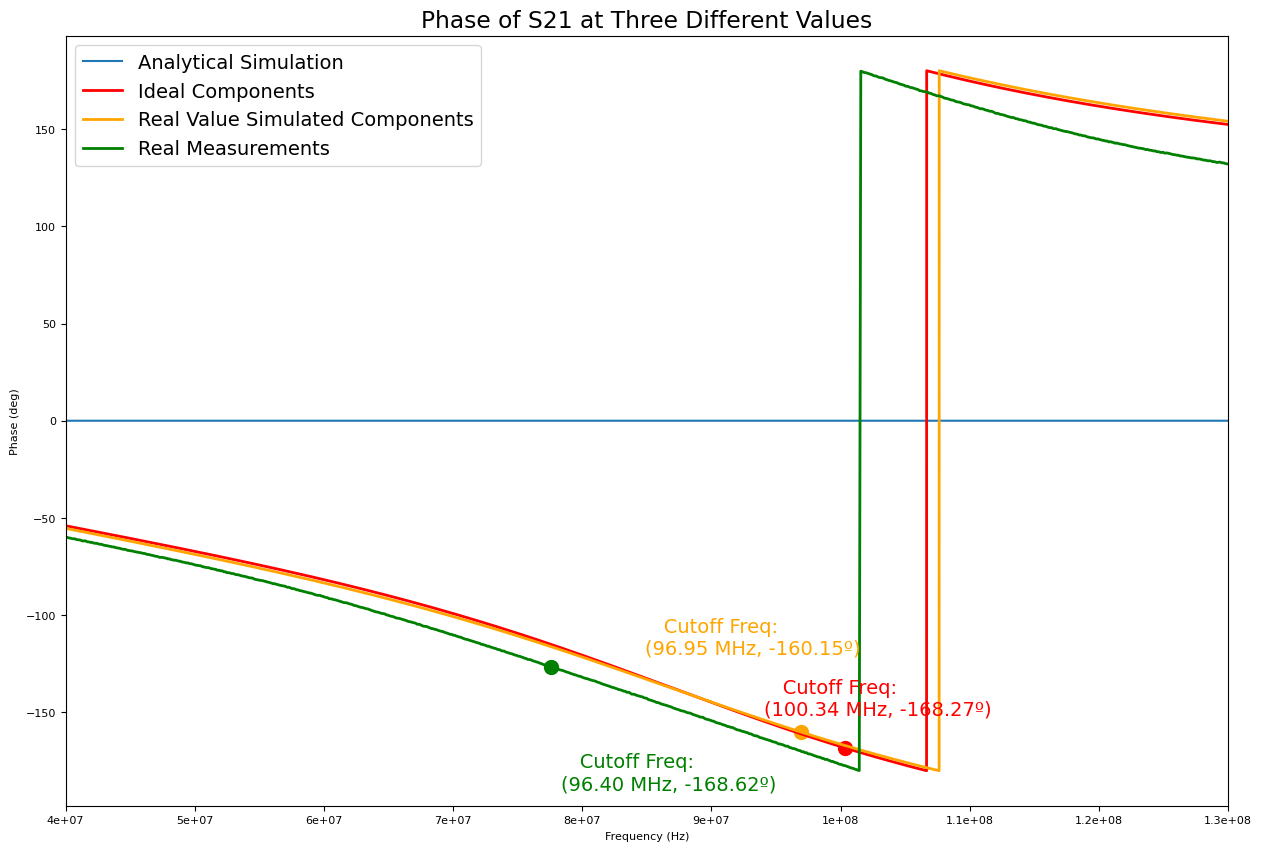

In [60]:
fig, ax = plt.subplots(1,1, figsize=[15,10])
plt.rcParams['font.size'] = 15

 ################################## 0, 0 -> analytical ################################
axCurr = ax
axCurr.set_title("Magnitude of Analytical Model S21")
axCurr.set_xlabel("Frequency (Hz)")
axCurr.set_ylabel("Phase (Degrees)")
end = -1

db = analytical_db; freq = analytical_freq; deg = s21_AnalyticalSim.s_deg[:,0,0]

loc1 = find(db, -1)
loc3 = find(db, -3)
locMax = find(db, 100)
locMin = find(db[:int(len(db)/4)], -1000)

line1 = axCurr.plot(freq, deg, label="Analytical Simulation")

plt.rcParams['font.size'] = 14
# axCurr.scatter(freq[loc1], deg[loc1], c='blue')
# s21_AnalyticalSim.plot_s_deg(ax=axCurr, color="blue", linewidth=2)


 ################################## 0, 1 -> idealized components ################################
axCurr = ax
axCurr.set_title("Magnitude of Ideal Component Simulated Model S21")
axCurr.set_xlabel("Frequency (Hz)")
axCurr.set_ylabel("Attenuation (dB)")

db = s21_IdealSim.s_db[:,0,0]
freq = s21_IdealSim.f
deg = s21_IdealSim.s_deg[:,0,0]

line2 = s21_IdealSim.plot_s_deg(ax=axCurr, color="red", linewidth=2, label="Ideal Components")

loc1 = find(db, -1)
loc3 = find(db, -3)
locMax = find(db, 100)
locMin = find(db[:int(len(db)/4)], -1000)


axCurr.scatter(freq[loc3], deg[loc3], c='red', s=100)
axCurr.annotate(f"   Cutoff Freq: \n({freq[loc3]/1e6:0.2f} MHz, {deg[loc3]:0.2f}º)", 
                                     (freq[loc3] * 7.5/8,    deg[loc3] * 7.2/8) , color="red")


 ################################## 1, 0 -> real simulated components ################################
axCurr = ax
axCurr.set_title("Magnitude of Real Components Simulated Model S21")
axCurr.set_xlabel("Frequency (Hz)")
axCurr.set_ylabel("Attenuation (dB)")

db = s21_RealSim.s_db[:,0,0]
freq = s21_RealSim.f
deg = s21_RealSim.s_deg[:,0,0]

line3 = s21_RealSim.plot_s_deg(ax=axCurr, color="orange", linewidth=2, label="Real Value Simulated Components")

loc1 = find(db, -1)
loc3 = find(db, -3)
locMax = find(db, 100)
locMin = find(db[:int(len(db)/4)], -1000)


axCurr.scatter(freq[loc3], deg[loc3], c='orange', s=100)
axCurr.annotate(f"   Cutoff Freq: \n({freq[loc3]/1e6:0.2f} MHz, {deg[loc3]:0.2f}º)", 
                                     (freq[loc3] * 7/8,    6/8 * deg[loc3]), color="orange" )

 ################################## 1, 1 -> lab data ################################
axCurr = ax
axCurr.set_title("Phase of S21 at Three Different Values")
axCurr.set_xlabel("Frequency (Hz)")
axCurr.set_ylabel("Attenuation (dB)")

line4 = real_data_21.plot_s_deg(ax=axCurr, color="green", linewidth=2, label="Real Measurements")

db = real_data_21.s_db[:,0,0]
freq = real_data_21.f
deg = real_data_21.s_deg[:,0,0]

loc1 = find(db[int(len(db)/10):], -1) + int(len(db)/10)
loc3 = find(db, -3)
locMax = find(db, 100)
locMin = find(db[:int(len(db)/4)], -1000)

axCurr.scatter(freq[loc1], deg[loc1], c='green', s=100)
axCurr.annotate(f"   Cutoff Freq: \n({freq[loc3]/1e6:0.2f} MHz, {deg[loc3]:0.2f}º)", 
                                     (freq[loc3] * 6.5/8,   9/8*deg[loc3]), color="green" )



In [61]:
analytical_freq, analytical_db = buildAtt(0, 300e6)
s21_AnalyticalSim = rf.Network(frequency = analytical_freq, s = analytical_db)

analytical_freq = analytical_freq/(2*np.pi)
analytical_db = -analytical_db

Epsilon  0.34931140018894796


In [62]:
filename = "dp1_1_to_300M.txt"
frequency_arr = []
s_arr = []

with open(filename, 'r') as input_file:
    line_array = input_file.readlines()

    # Change first line to s1p format
    line_array[0] = "# MHz S MA R 50"

    j = 0
    # LTspice exports with commas, change to spaces
    for idx, line in enumerate(line_array[1:]):
        line_array[idx] = line.replace(",", " ")
        
        arr = [float(x) for x in line_array[idx].split()]
        
        frequency_arr.append(arr[0])
        
        s_arr.append([[arr[1]+1j*arr[2], arr[3]+1j*arr[4]],
                      [arr[5]+1j*arr[6], arr[7]+1j*arr[8]]])

f_arr = np.array(frequency_arr)
svals_arr = np.array(s_arr)

s21_IdealSim = rf.Network(frequency = f_arr, s = svals_arr[:,1,0])

In [63]:
filename = "dp1_0to300M_real.txt"

frequency_arr = []
s_arr = []

with open(filename, 'r') as input_file:
    line_array = input_file.readlines()

    # Change first line to s1p format
    line_array[0] = "# MHz S MA R 50"

    j = 0
    # LTspice exports with commas, change to spaces
    for idx, line in enumerate(line_array[1:]):
        line_array[idx] = line.replace(",", " ")
        
        arr = [float(x) for x in line_array[idx].split()]
        
        frequency_arr.append(arr[0])
        
        s_arr.append([[arr[1]+1j*arr[2], arr[3]+1j*arr[4]],
                      [arr[5]+1j*arr[6], arr[7]+1j*arr[8]]])

f_arr = np.array(frequency_arr)
svals_arr = np.array(s_arr)

s21_RealSim = rf.Network(frequency = f_arr, s = svals_arr[:,1,0])

In [64]:
csv10 = pd.read_csv('CSV10.csv', skiprows=13)
csv10.columns = ['Frequency', 'Z_Real', 'Z_Imag', 'components', 'H']
csv10['Z_n'] = csv10['Z_Real']/50 + 1j*csv10['Z_Imag']/50
csv10['S_21'] = ( csv10['Z_n']-1 ) / ( csv10['Z_n']+1 )
real_data_21 = rf.Network(frequency = csv10['Frequency'], s = csv10['S_21'], m=0, n=0)

In [65]:
print(csv10['S_21'])

0      0.991975-0.016237j
1      0.988340-0.022850j
2      0.989480-0.039872j
3      0.988569-0.047667j
4      0.986244-0.059877j
              ...        
745    0.004045+0.011138j
746    0.004102+0.011102j
747    0.003906+0.010960j
748    0.004084+0.011052j
749    0.004021+0.010935j
Name: S_21, Length: 750, dtype: complex128


Cutoff:  99956499.95649996
0, 0: Max-Min: 0.4999990511340464 Insertion:  -0.0
Cutoff:  100330033.668862
0, 0: Max-Min: 0.49092962564262177 Insertion:  -8.68584255884301e-05
Cutoff:  96939693.9694646
0, 0: Max-Min: 0.6381058895463632 Insertion:  -0.23157802098913333
Cutoff:  96467870.0
0, 0: Max-Min: 0.9154496682728998 Insertion:  -0.06881931174276346


Text(25386540.0, -20.008790200904443, '   Stopband Freq: \n(169.24 MHz, -20.01 dB)')

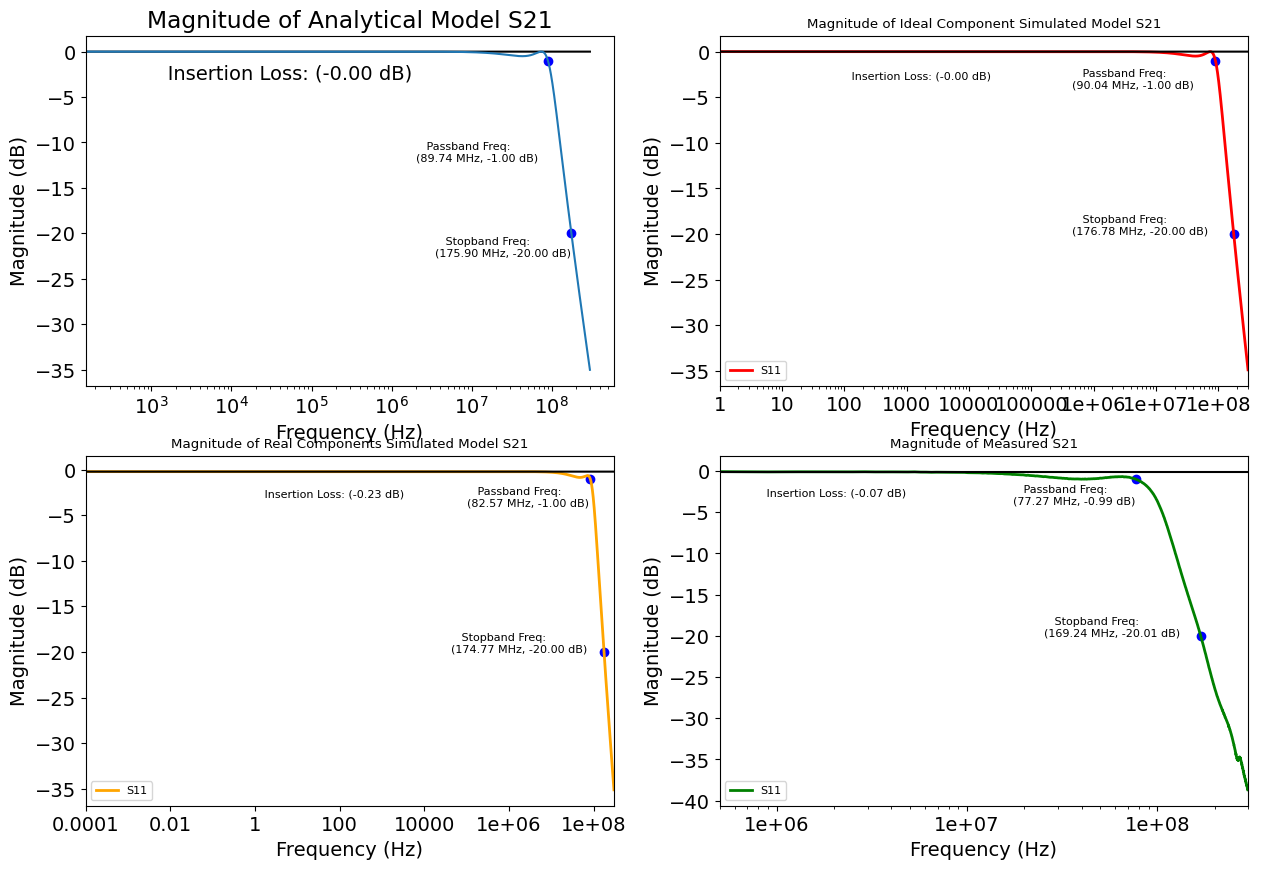

In [66]:
fig, axes = plt.subplots(2,2, figsize=[15,10])
axes[0][0].set_xscale("log")
axes[0][1].set_xscale("log")
axes[1][0].set_xscale("log")
axes[1][1].set_xscale("log")

############################# 0, 0 -> analytical #############################
axCurr = axes[0][0]
axCurr.set_title("Magnitude of Analytical Model S21")
axCurr.set_xlabel("Frequency (Hz)")
axCurr.set_ylabel("Magnitude (dB)")
end = -1

db = analytical_db; freq = analytical_freq

insertionLoss = db[0]
insertion_line = insertionLoss * np.ones(len(db))
axCurr.plot(freq, insertion_line, c="black")
axCurr.annotate(f"   Insertion Loss: ({insertionLoss:0.2f} dB)", (0.001*freq[loc1]*10,  -3), color="black")

loc1 = find(db, -1)
loc3 = find(db, -3)
loc20 = find(db, -20)

print("Cutoff: ", freq[loc3])

print("0, 0: Max-Min:", db[find(db, 100)]-db[find(db[:int(len(db)/4)], -1e10)], "Insertion: ", db[0])
axCurr.plot(freq, db)

plt.rcParams['font.size'] = 8
axCurr.scatter(freq[loc1], db[loc1], c='blue')
axCurr.annotate(f"   Passband Freq: \n({freq[loc1]/1e6:0.2f} MHz, {db[loc1]:0.2f} dB)", 
                                   (    0.02 *freq[loc3],       4 * db[loc3]))

axCurr.scatter(freq[loc20], db[loc20], c='blue')
axCurr.annotate(f"   Stopband Freq: \n({freq[loc20]/1e6:0.2f} MHz, {db[loc20]:0.2f} dB)", 
                                     (0.02 * freq[loc20],          9/8 * db[loc20]) )

axes[0][0].set_xscale("log")

############################# 0, 1 -> idealized components #############################
axCurr = axes[0][1]
axCurr.set_title("Magnitude of Ideal Component Simulated Model S21")
axCurr.set_xlabel("Frequency (Hz)")
axCurr.set_ylabel("Attenuation (dB)")

db = s21_IdealSim.s_db[:,0,0]
freq = s21_IdealSim.f

s21_IdealSim.plot_s_db(ax=axCurr, color="red", linewidth=2)

loc1 = find(db, -1)
loc3 = find(db, -3)
loc20 = find(db, -20)

print("Cutoff: ", freq[loc3])

print("0, 0: Max-Min:", db[find(db, 100)]-db[find(db[:int(len(db)/4)], -1e10)], "Insertion: ", db[0])

insertionLoss = db[0]
insertion_line = insertionLoss * np.ones(len(db))
axCurr.plot(freq, insertion_line, c="black")
axCurr.annotate(f"   Insertion Loss: ({insertionLoss:0.2f} dB)", (1e-6*freq[loc1],  -3), color="black")

plt.rcParams['font.size'] = 8
axCurr.scatter(freq[loc1], db[loc1], c='blue')
axCurr.annotate(f"   Passband Freq: \n({freq[loc1]/1e6:0.2f} MHz, {db[loc1]:0.2f} dB)", 
                                   (    freq[loc1]* 0.02/4,     4 * db[loc1]))

axCurr.scatter(freq[loc20], db[loc20], c='blue')
axCurr.annotate(f"   Stopband Freq: \n({freq[loc20]/1e6:0.2f} MHz, {db[loc20]:0.2f} dB)", 
                                     (freq[loc20] * 0.01/4,                db[loc20]) )

############################# 1, 0 -> real simulated components #############################
axCurr = axes[1][0]
axCurr.set_title("Magnitude of Real Components Simulated Model S21")
axCurr.set_xlabel("Frequency (Hz)")
axCurr.set_ylabel("Attenuation (dB)")

db = s21_RealSim.s_db[:,0,0]
freq = s21_RealSim.f

s21_RealSim.plot_s_db(ax=axCurr, color="orange", linewidth=2)

loc1 = find(db, -1)
loc3 = find(db, -3)
loc20 = find(db, -20)

print("Cutoff: ", freq[loc3])

print("0, 0: Max-Min:", db[find(db, 100)]-db[find(db[:int(len(db)/4)], -1e10)], "Insertion: ", db[0])

insertionLoss = db[0]
insertion_line = insertionLoss * np.ones(len(db))
axCurr.plot(freq, insertion_line, c="black")
axCurr.annotate(f"   Insertion Loss: ({insertionLoss:0.2f} dB)", (1e-8*freq[loc3],  -3), color="black")

plt.rcParams['font.size'] = 8
axCurr.scatter(freq[loc1], db[loc1], c='blue')
axCurr.annotate(f"   Passband Freq: \n({freq[loc1]/1e6:0.2f} MHz, {db[loc1]:0.2f} dB)", 
                                   (    freq[loc1]* 0.005/4,     4 * db[loc1]))

axCurr.scatter(freq[loc20], db[loc20], c='blue')
axCurr.annotate(f"   Stopband Freq: \n({freq[loc20]/1e6:0.2f} MHz, {db[loc20]:0.2f} dB)", 
                                     (freq[loc20] * 0.001/4,                db[loc20]) )


############################# 1, 1 -> lab data #############################
axCurr = axes[1][1]
axCurr.set_title("Magnitude of Measured S21")
axCurr.set_xlabel("Frequency (Hz)")
axCurr.set_ylabel("Attenuation (dB)")

real_data_21.plot_s_db(ax=axCurr, color="green", linewidth=2)

db = real_data_21.s_db[:,0,0]
freq = real_data_21.f

loc1 = find(db[int(len(db)/10):], -1) + int(len(db)/10)
loc3 = find(db, -3)
loc20 = find(db, -20)

print("Cutoff: ", freq[loc3])

print("0, 0: Max-Min:", db[find(db, 100)]-db[find(db[:int(len(db)/4)], -1e10)], "Insertion: ", real_data_21.s_db[:,0,0][0])

insertionLoss = db[0]
insertion_line = insertionLoss * np.ones(len(db))
axCurr.plot(freq, insertion_line, c="black")
axCurr.annotate(f"   Insertion Loss: ({insertionLoss:0.2f} dB)", (0.001*freq[loc1]*10,  -3), color="black")

plt.rcParams['font.size'] = 8
axCurr.scatter(freq[loc1], db[loc1], c='blue')
axCurr.annotate(f"   Passband Freq: \n({freq[loc1]/1e6:0.2f} MHz, {db[loc1]:0.2f} dB)", 
                                   (    freq[loc1]* 0.9/4,     4 * db[loc1]))

axCurr.scatter(freq[loc20], db[loc20], c='blue')
axCurr.annotate(f"   Stopband Freq: \n({freq[loc20]/1e6:0.2f} MHz, {db[loc20]:0.2f} dB)", 
                                     (freq[loc20] * 0.6/4,                db[loc20]) )

## Calculate S11 of the Analytical Model
S_21^2 + S_11^2 = 1; in a lossless circuit, then, the value of S_11 = sqrt(1 - S_21^2)

https://www.edaboard.com/threads/convert-s11-into-s21-graph-for-filter-passband-sweeps.349264/

In [67]:
f_11, analytical_model_11 = buildAtt(0, 300e6)

Epsilon  0.34931140018894796


In [68]:
filename = "dp1_1_to_300M.txt"
frequency_arr = []
s_arr = []

with open(filename, 'r') as input_file:
    line_array = input_file.readlines()

    # Change first line to s1p format
    line_array[0] = "# MHz S MA R 50"

    j = 0
    # LTspice exports with commas, change to spaces
    for idx, line in enumerate(line_array[1:]):
        line_array[idx] = line.replace(",", " ")
        
        arr = [float(x) for x in line_array[idx].split()]
        
        frequency_arr.append(arr[0])
        
        s_arr.append([[arr[1]+1j*arr[2], arr[3]+1j*arr[4]],
                      [arr[5]+1j*arr[6], arr[7]+1j*arr[8]]])

f_arr = np.array(frequency_arr)
svals_arr = np.array(s_arr)

s11_IdealSim = rf.Network(frequency = f_arr, s = svals_arr[:,0,0])

In [69]:
filename = "dp1_0to300M_real.txt"

frequency_arr = []
s_arr = []

with open(filename, 'r') as input_file:
    line_array = input_file.readlines()

    # Change first line to s1p format
    line_array[0] = "# MHz S MA R 50"

    j = 0
    # LTspice exports with commas, change to spaces
    for idx, line in enumerate(line_array[1:]):
        line_array[idx] = line.replace(",", " ")
        
        arr = [float(x) for x in line_array[idx].split()]
        
        frequency_arr.append(arr[0])
        
        s_arr.append([[arr[1]+1j*arr[2], arr[3]+1j*arr[4]],
                      [arr[5]+1j*arr[6], arr[7]+1j*arr[8]]])

f_arr = np.array(frequency_arr)
svals_arr = np.array(s_arr)

s11_RealSim = rf.Network(frequency = f_arr, s = svals_arr[:,0,0])

In [70]:
csv6 = pd.read_csv('CSV9.csv', skiprows=13)
csv6.columns = ['Frequency', 'Z_Real', 'Z_Imag', 'components', 'H']
csv6['Z_n'] = csv6['Z_Real']/50 + 1j*csv6['Z_Imag']/50
csv6['S_21'] = ( csv6['Z_n']-1 ) / ( csv6['Z_n']+1 )
real_data_11 = rf.Network(frequency = csv6['Frequency'], s = csv6['S_21'])

In [71]:
def getOneAtt(w):

    freq_cutoff = 100e6
    omega_cutoff = freq_cutoff * 2 * np.pi
    pb_allowable_ripple = 0.5 # 1dB of allowable ripple in the passband
    
    epsilon = np.sqrt( np.pow(10, pb_allowable_ripple / 10) - 1)
    print("Epsilon ", epsilon)
    
    n = 3 # order that we're using
    
    B = 1/n * np.arccosh(1/epsilon)
    inv_ratio = (w/omega_cutoff) * np.cosh(B) # (w/wc)'

    attenuation = 10 * np.log10(1 + np.power(epsilon, 2) * np.power( C_3(inv_ratio), 2)  )
    return attenuation

[1.00000000e+00 1.00000000e+00 9.99999999e-01 ... 9.52455850e-36
 9.52396242e-36 9.52336638e-36]


/var/folders/rj/sr4h5_xd2g9bw0xqc0qk5wm40000gn/T/ipykernel_47897/4037145578.py:17: RuntimeWarning: divide by zero encountered in log
  s11_vals = 10 * np.log(s11_linear)


Text(25386540.0, -1.1675073608352342, '   Stopband Freq: \n(169.24 MHz, -0.39 dB)')

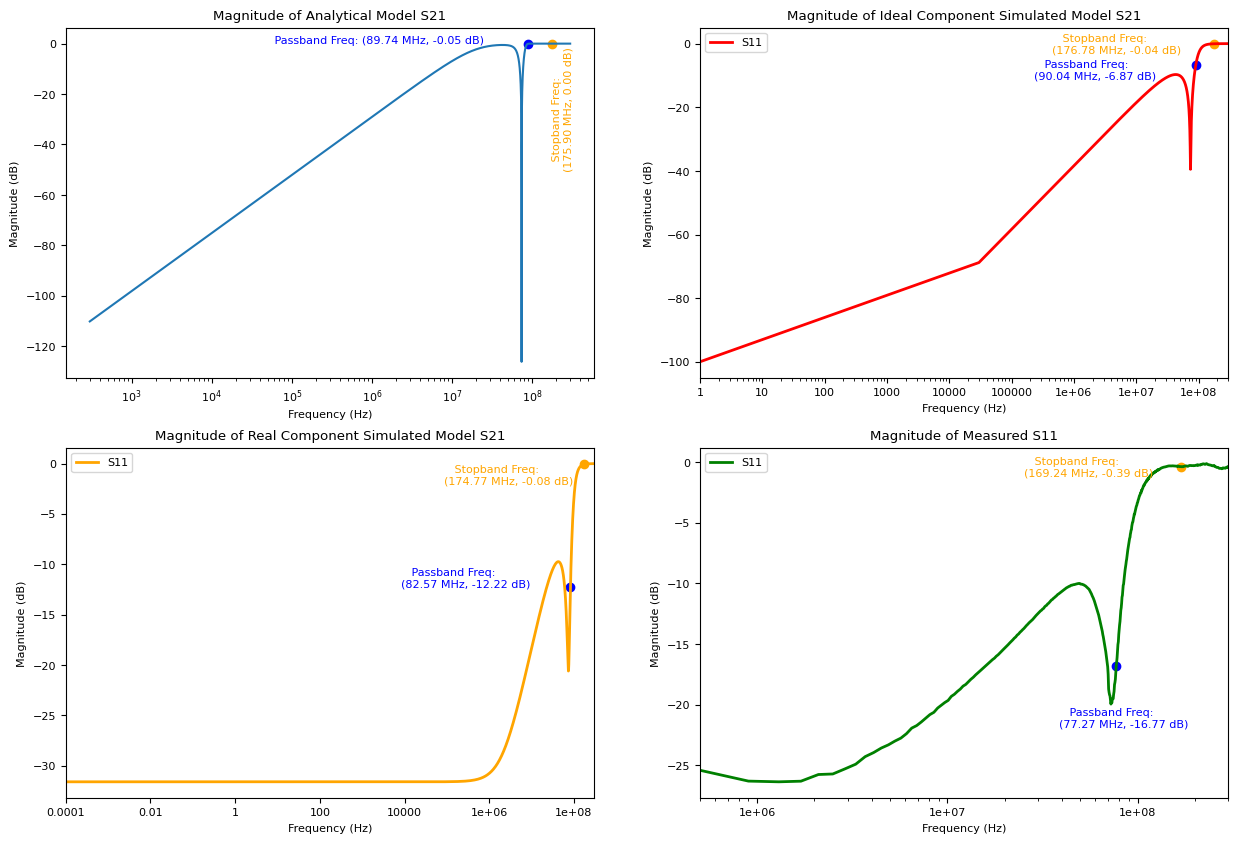

In [73]:
fig, axes = plt.subplots(2,2, figsize=[15,10])
axes[0][0].set_xscale("log")
axes[0][1].set_xscale("log")
axes[1][0].set_xscale("log")
axes[1][1].set_xscale("log")

############################# 0, 0 -> analytical #############################
axCurr = axes[0][0]
axCurr.set_title("Magnitude of Analytical Model S21")
axCurr.set_xlabel("Frequency (Hz)")
axCurr.set_ylabel("Magnitude (dB)")
end = -1

s21_linear = np.power(10, -analytical_model_11)
print(s21_linear)
s11_linear = np.sqrt(np.square(1) - np.square(s21_linear))
s11_vals = 10 * np.log(s11_linear)

freq = analytical_freq

analytical_loc_pb = find(analytical_db, -1) # finds for s21
analytical_loc_stop = find(analytical_db, -20)

axCurr.plot(freq, s11_vals)

plt.rcParams['font.size'] = 8
axCurr.scatter(freq[analytical_loc_pb], s11_vals[analytical_loc_pb], c='blue')
axCurr.annotate(f"   Passband Freq: ({freq[analytical_loc_pb]/1e6:0.2f} MHz, {s11_vals[analytical_loc_pb]:0.2f} dB)", 
                                   (  0.0005 * freq[analytical_loc_pb],   0.9 * s11_vals[analytical_loc_pb]), color="blue")

axCurr.scatter(freq[analytical_loc_stop], s11_vals[analytical_loc_stop], c='orange')
axCurr.annotate(f"   Stopband Freq: \n({freq[analytical_loc_stop]/1e6:0.2f} MHz, {s11_vals[analytical_loc_stop]:0.2f} dB)", 
                                     ( freq[analytical_loc_stop],          -50), color="orange", rotation="vertical")

axes[0][0].set_xscale("log")

############################# 0, 1 -> idealized components #############################
axCurr = axes[0][1]
axCurr.set_title("Magnitude of Ideal Component Simulated Model S21")
axCurr.set_xlabel("Frequency (Hz)")
axCurr.set_ylabel("Attenuation (dB)")

db = s11_IdealSim.s_db[:,0,0]
freq = s11_IdealSim.f

s11_IdealSim.plot_s_db(ax=axCurr, color="red", linewidth=2)

s21_ideal = s21_IdealSim.s_db[:,0,0]
loc1 = find(s21_ideal, -1)
loc3 = find(s21_ideal, -3)
loc20 = find(s21_ideal, -20)

plt.rcParams['font.size'] = 8
axCurr.scatter(                         freq[loc1],                 db[loc1], c='blue')
axCurr.annotate(f"   Passband Freq: \n({freq[loc1]/1e6:0.2f} MHz, { db[loc1]:0.2f} dB)", 
                                   (    freq[loc1] * 0.01/4,  1.6 *  db[loc1]), color="blue")

axCurr.scatter(freq[loc20], db[loc20], c='orange')
axCurr.annotate(f"   Stopband Freq: \n({freq[loc20]/1e6:0.2f} MHz, {db[loc20]:0.2f} dB)", 
                                     (freq[loc20] * 0.01/4,      0.7e2 * db[loc20]), color="orange")

############################ 1, 0 -> real world components #############################
axCurr = axes[1][0]
axCurr.set_title("Magnitude of Real Component Simulated Model S21")
axCurr.set_xlabel("Frequency (Hz)")
axCurr.set_ylabel("Attenuation (dB)")

db = s11_RealSim.s_db[:,0,0]
freq = s11_RealSim.f

s11_RealSim.plot_s_db(ax=axCurr, color="orange", linewidth=2)

s21_real = s21_RealSim.s_db[:,0,0]
loc1 = find(s21_RealSim.s_db[:,0,0], -1)
loc3 = find(s21_RealSim.s_db[:,0,0], -3)
loc20 = find(s21_RealSim.s_db[:,0,0], -20)

plt.rcParams['font.size'] = 8
axCurr.scatter(freq[loc1], db[loc1], c='blue')
axCurr.annotate(f"   Passband Freq: \n({freq[loc1]/1e6:0.2f} MHz, {db[loc1]:0.2f} dB)", 
                                   ( 0.0001 * freq[loc1],  db[loc1]), color="blue")

axCurr.scatter(freq[loc20], db[loc20], c='orange')
axCurr.annotate(f"   Stopband Freq: \n({freq[loc20]/1e6:0.2f} MHz, {db[loc20]:0.2f} dB)", 
                                     (freq[loc20] * 0.0005,     25 *  db[loc20]), color="orange" )

############################# 1, 1 -> lab data #############################
axCurr = axes[1][1]
axCurr.set_title("Magnitude of Measured S11")
axCurr.set_xlabel("Frequency (Hz)")
axCurr.set_ylabel("Attenuation (dB)")

real_data_11.plot_s_db(ax=axCurr, color="green", linewidth=2)

db = real_data_11.s_db[:,0,0]
freq = real_data_11.f

rdb_21 = real_data_21.s_db[:,0,0]
loc1 = find(rdb_21[int(len(rdb_21)/10):], -1) + int(len(rdb_21)/10)
loc3 = find(rdb_21, -3)
loc20 = find(rdb_21, -20)


plt.rcParams['font.size'] = 8
axCurr.scatter(freq[loc1], db[loc1], c='blue')
axCurr.annotate(f"   Passband Freq: \n({freq[loc1]/1e6:0.2f} MHz, {db[loc1]:0.2f} dB)", 
                                   (  0.5 * freq[loc1],    1.3 * db[loc1]), color="blue")

axCurr.scatter(freq[loc20], db[loc20], c='orange')
axCurr.annotate(f"   Stopband Freq: \n({freq[loc20]/1e6:0.2f} MHz, {db[loc20]:0.2f} dB)", 
                                     (freq[loc20] * 0.6/4,            3 * db[loc20]), color="orange" )


In [20]:
csv6 = pd.read_csv('CSV10.csv', skiprows=13)
csv6.columns = ['Frequency', 'Z_Real', 'Z_Imag', 'components', 'H']
print(min(csv6['Frequency'])/1e6)

0.4998667


In [21]:
filename = "dp1_1_to_300M.txt"
frequency_arr = []
s_arr = []

with open(filename, 'r') as input_file:
    line_array = input_file.readlines()

    # Change first line to s1p format
    line_array[0] = "# MHz S MA R 50"

    j = 0
    # LTspice exports with commas, change to spaces
    for idx, line in enumerate(line_array[1:]):
        line_array[idx] = line.replace(",", " ")
        
        arr = [float(x) for x in line_array[idx].split()]
        
        frequency_arr.append(arr[0])
        
        s_arr.append([[arr[1]+1j*arr[2], arr[3]+1j*arr[4]],
                      [arr[5]+1j*arr[6], arr[7]+1j*arr[8]]])

f_arr = np.array(frequency_arr)
svals_arr = np.array(s_arr)

smith_11_IdealSim = rf.Network(frequency = f_arr, s = svals_arr[:,0,0])
smith_21_IdealSim = rf.Network(frequency = f_arr, s = svals_arr[:,1,0])

In [22]:
filename = "dp1_0to300M_real.txt"

frequency_arr = []
s_arr = []

with open(filename, 'r') as input_file:
    line_array = input_file.readlines()

    # Change first line to s1p format
    line_array[0] = "# MHz S MA R 50"

    j = 0
    # LTspice exports with commas, change to spaces
    for idx, line in enumerate(line_array[1:]):
        line_array[idx] = line.replace(",", " ")
        
        arr = [float(x) for x in line_array[idx].split()]
        
        frequency_arr.append(arr[0])
        
        s_arr.append([[arr[1]+1j*arr[2], arr[3]+1j*arr[4]],
                      [arr[5]+1j*arr[6], arr[7]+1j*arr[8]]])

f_arr = np.array(frequency_arr)
svals_arr = np.array(s_arr)

smith_11_RealSim = rf.Network(frequency = f_arr, s = svals_arr[:,0,0])
smith_21_RealSim = rf.Network(frequency = f_arr, s = svals_arr[:,1,0])

In [23]:
csv_s11 = pd.read_csv('CSV9.csv', skiprows=13)
csv_s11.columns = ['Frequency', 'Z_Real', 'Z_Imag', 'components', 'H']
csv_s11['Z_n'] = csv_s11['Z_Real']/50 + 1j*csv_s11['Z_Imag']/50
csv_s11['S_21'] = ( csv_s11['Z_n']-1 ) / ( csv_s11['Z_n']+1 )
real_data_11 = rf.Network(frequency = csv_s11['Frequency'], s = csv_s11['S_21'])

csv_s21 = pd.read_csv('CSV10.csv', skiprows=13)
csv_s21.columns = ['Frequency', 'Z_Real', 'Z_Imag', 'components', 'H']
csv_s21['Z_n'] = csv_s21['Z_Real']/50 + 1j*csv_s21['Z_Imag']/50
csv_s21['S_21'] = ( csv_s21['Z_n']-1 ) / ( csv_s21['Z_n']+1 )
real_data_21 = rf.Network(frequency = csv_s21['Frequency'], s = csv_s21['S_21'], m=0, n=0)

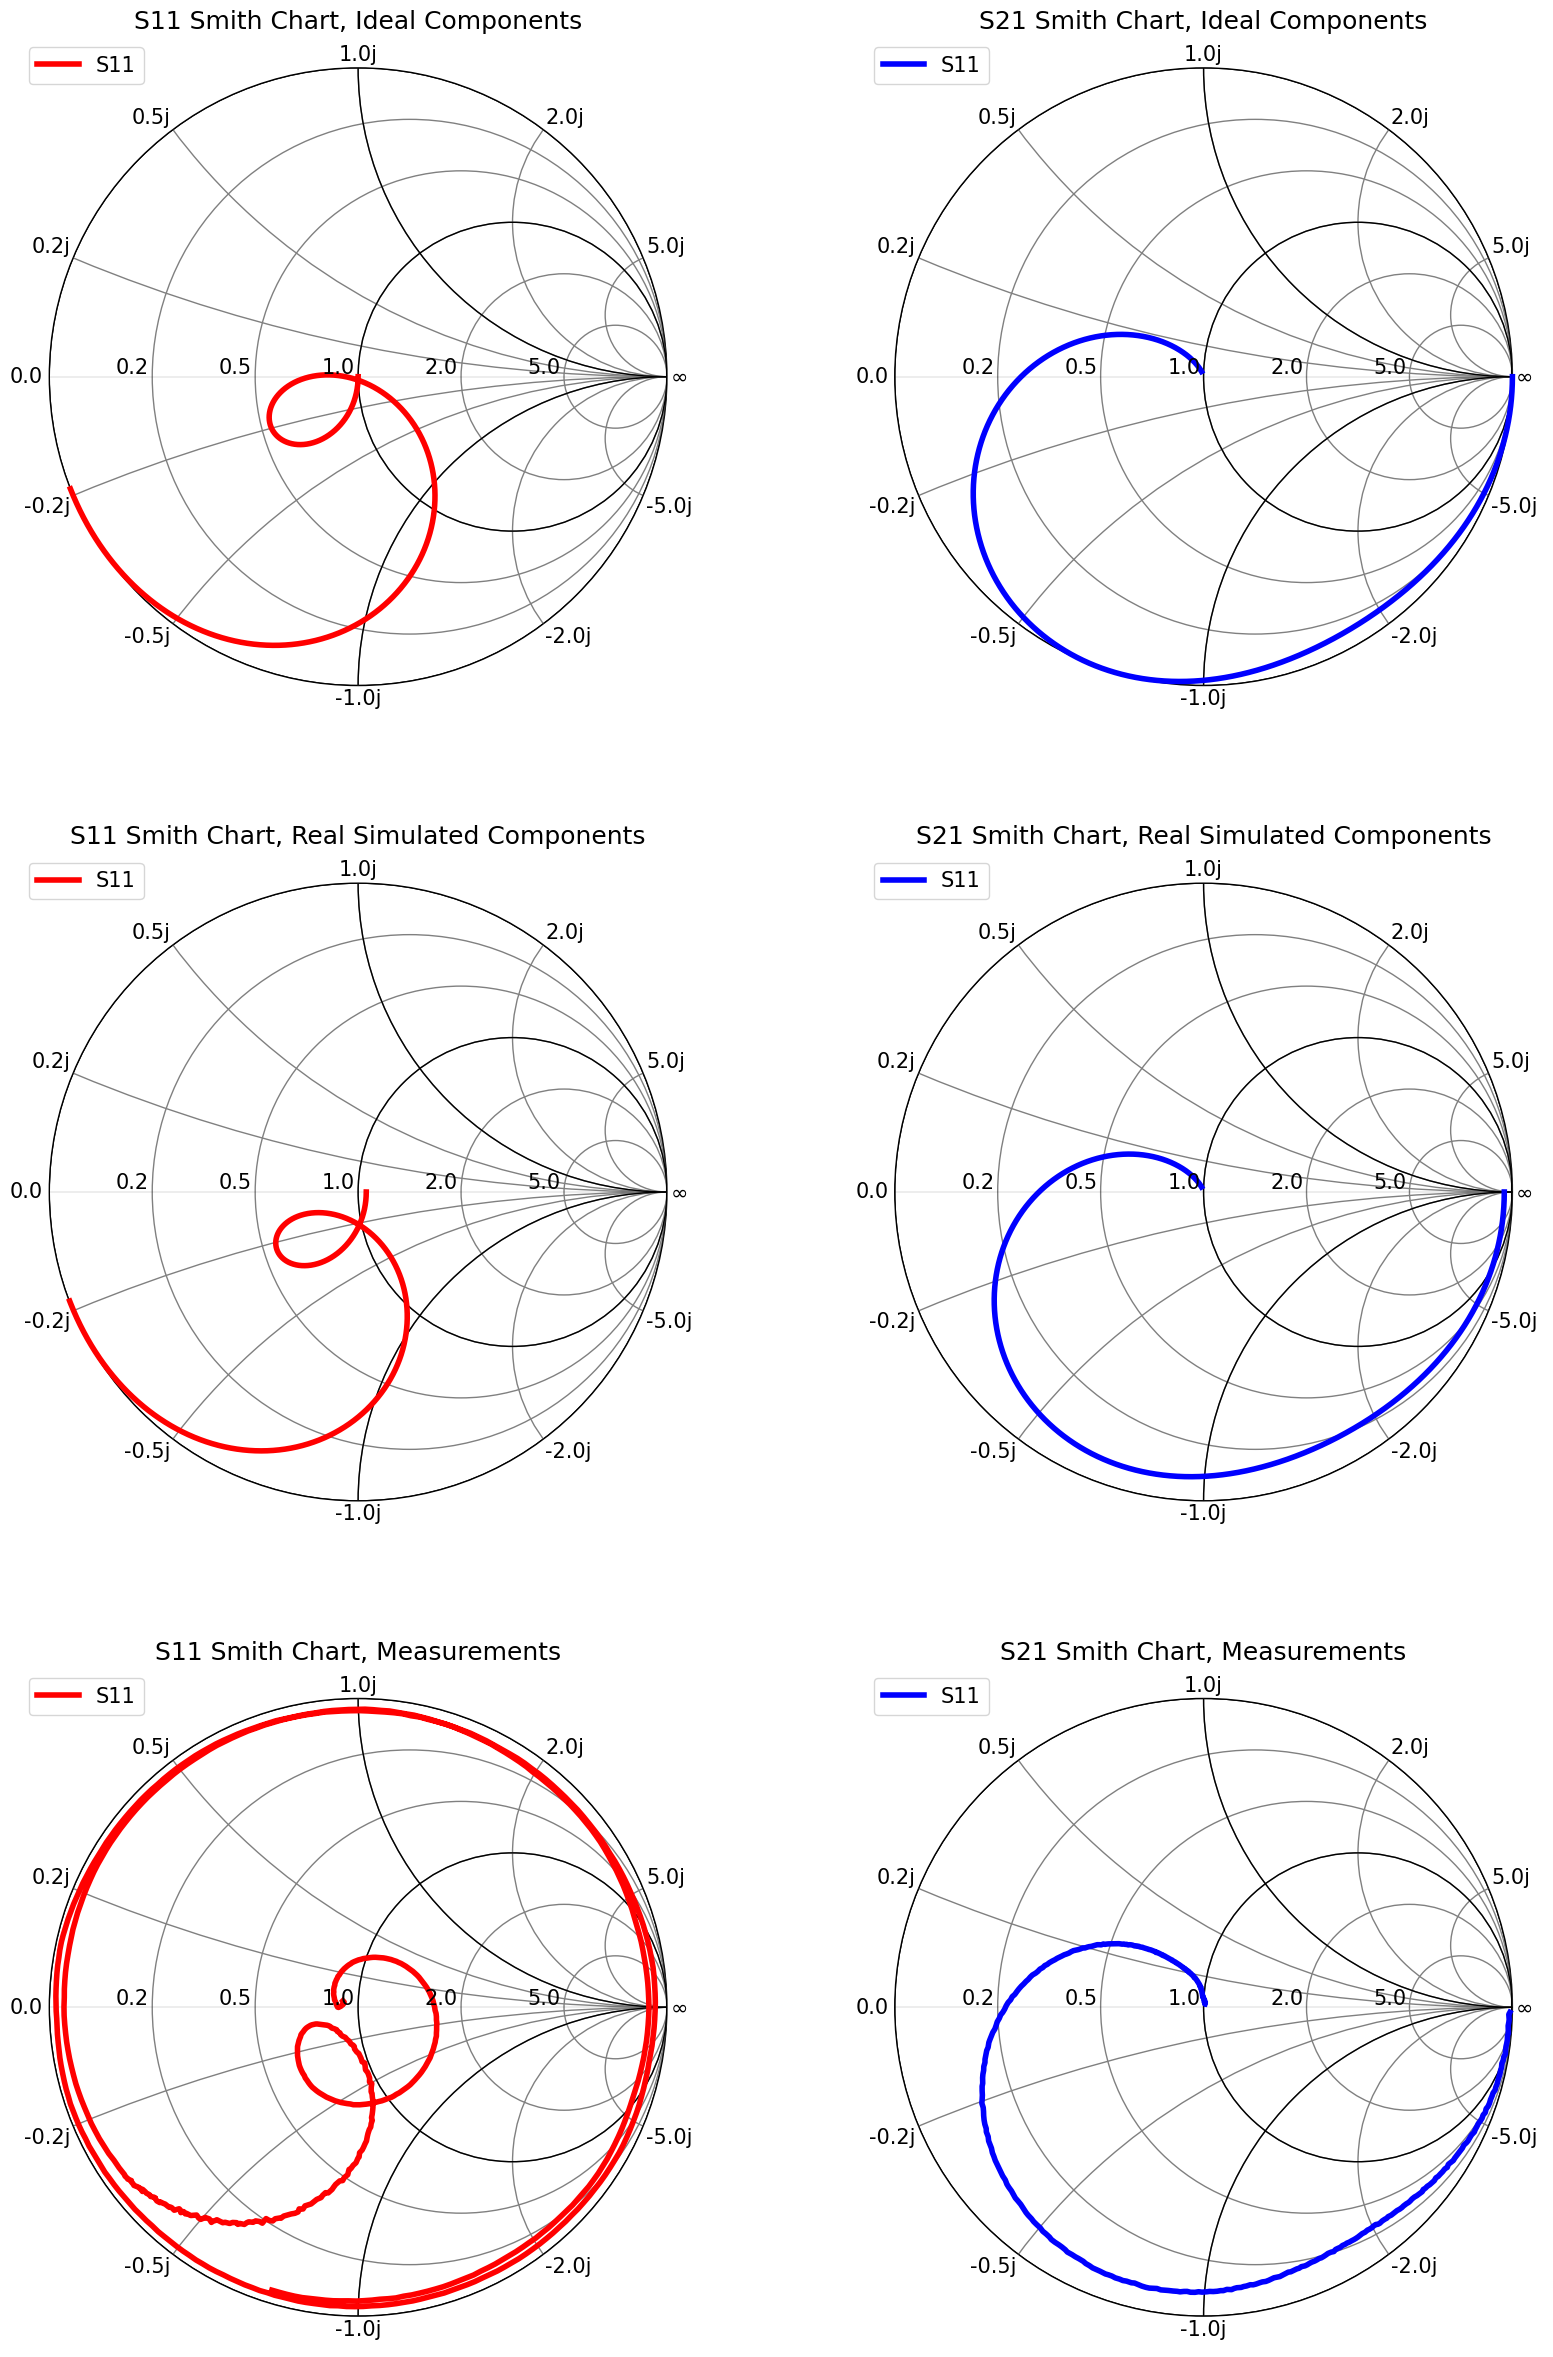

In [24]:
fig, axes = plt.subplots(3,2, figsize=[20,30])
plt.rcParams['font.size'] = 15

############################# 0, 0 -> ideal #############################
axCurr = axes[0,0]
axCurr.set_title("S11 Smith Chart, Ideal Components")

smith_11_IdealSim.plot_s_smith(ax=axCurr, draw_labels=True, color='r', linewidth=4)

############################# 0, 0 -> analytical #############################
axCurr = axes[0,1]
axCurr.set_title("S21 Smith Chart, Ideal Components")

smith_21_IdealSim.plot_s_smith(ax=axCurr, draw_labels=True, color='b', linewidth=4)

############################# 0, 0 -> real #############################
axCurr = axes[1,0]
axCurr.set_title("S11 Smith Chart, Real Simulated Components")

smith_11_RealSim.plot_s_smith(ax=axCurr, draw_labels=True, color='r', linewidth=4)

############################# 0, 0 -> analytical #############################
axCurr = axes[1,1]
axCurr.set_title("S21 Smith Chart, Real Simulated Components")

smith_21_RealSim.plot_s_smith(ax=axCurr, draw_labels=True, color='b', linewidth=4)

############################# 0, 0 -> ideal #############################
axCurr = axes[2,0]
axCurr.set_title("S11 Smith Chart, Measurements")

real_data_11.plot_s_smith(ax=axCurr, draw_labels=True, color='r', linewidth=4)

############################# 0, 0 -> analytical #############################
axCurr = axes[2,1]
axCurr.set_title("S21 Smith Chart, Measurements")

real_data_21.plot_s_smith(ax=axCurr, draw_labels=True, color='b', linewidth=4)